# Wi-Fi Hotspot Data Analysis Project

**Students:**
- Hana Bubalo (230302259)  
- Semiha Seker (230302395)

**Course Project – Python & Data Analysis**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


## 2. Generating the Dataset

The dataset is generated artificially to simulate Wi-Fi hotspots in different neighborhoods.


In [2]:
np.random.seed(42)
n = 200

data = {
    'neighborhood': np.random.choice(['Center', 'Old Town', 'New City', 'Ilidza'], n),
    'type': np.random.choice(['Free', 'Limited', 'Paid'], n, p=[0.6, 0.3, 0.1]),
    'provider': np.random.choice(['City_WiFi', 'Telecom_BH', 'Global_Net', np.nan], n),
    'latitude': np.random.uniform(43.82, 43.88, n),
    'longitude': np.random.uniform(18.33, 18.42, n),
    'speed_mbps': np.random.normal(45, 15, n)
}

df = pd.DataFrame(data)

# Adding outliers and missing values intentionally
df.loc[0:10, 'speed_mbps'] = 800
df.loc[20:30, 'provider'] = np.nan

df.head()


,neighborhood,type,provider,latitude,longitude,speed_mbps
0,New City,Free,City_WiFi,43.826187,18.345204,800.0
1,Ilidza,Limited,nan,43.874153,18.355073,800.0
2,Center,Free,nan,43.850315,18.345931,800.0
3,New City,Free,Telecom_BH,43.869587,18.337983,800.0
4,New City,Paid,Global_Net,43.839203,18.340857,800.0


## 2.g Statistical Features of the Dataset


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   neighborhood  200 non-null    object 
 1   type          200 non-null    object 
 2   provider      200 non-null    object 
 3   latitude      200 non-null    float64
 4   longitude     200 non-null    float64
 5   speed_mbps    200 non-null    float64
dtypes: float64(3), object(3)
memory usage: 9.5+ KB


**Comment on df.info():**

The dataset consists of 200 observations and 6 attributes. Three of the attributes
(neighborhood, type, and provider) are categorical variables, while the remaining
three (latitude, longitude, and speed_mbps) are numerical variables of type float.
The `provider` attribute contains missing values (189 non-null entries), whereas all
other attributes are complete. This indicates that missing value handling will be
necessary, especially for the provider column, before further analysis or model
training.

In [30]:
df.describe()

,latitude,longitude,speed_mbps
count,200.000000,200.000000,200.000000
mean,43.851240,18.373089,44.711056
std,0.018439,0.025095,14.299618
min,43.820650,18.331630,4.546700
25%,43.835331,18.351238,36.387661
50%,43.851524,18.372042,45.430167
75%,43.868667,18.395197,54.178848
max,43.879983,18.419096,84.485731


**Comment on df.describe():**

The numerical features show reasonable distributions for latitude and longitude,
which are limited to a specific geographic region. However, the maximum value of
`speed_mbps` is extremely high compared to the upper quartile, indicating the presence
of significant outliers. This is also reflected in the high standard deviation value,
which shows large variability in internet speeds. Additionally, the dataset contains
missing values in the `provider` column. These outliers and missing values may affect
statistical analysis and machine learning results and should be handled in the
preprocessing stage.

## 2.h Statistical Questions


1. **What is the average internet speed of all Wi-Fi hotspots?**

In [34]:
# 1. Mean speed of all hotspots
df['speed_mbps'].mean()

np.float64(44.71105597182415)

2. **Is there a correlation between latitude and internet speed?**


In [25]:
# 2. Correlation between latitude and speed
df['latitude'].corr(df['speed_mbps'])

np.float64(-0.019063177168048874)

3. **How many Wi-Fi hotspots are there in each neighborhood?**


In [26]:
# 3. Number of hotspots per neighborhood
df['neighborhood'].value_counts()

neighborhood
New City    54
Ilidza      54
Center      46
Old Town    46
Name: count, dtype: int64

4. **How many unique internet service providers are in the dataset?**

In [27]:
# 4. Number of unique providers
df['provider'].nunique()

5

5. **What is the average internet speed for each Wi-Fi type?**

In [36]:
# 5. Average speed per Wi-Fi type
df.groupby('type')['speed_mbps'].mean()

type
Free       43.524101
Limited    46.529520
Paid       45.475766
Name: speed_mbps, dtype: float64

## 3. Data Visualization


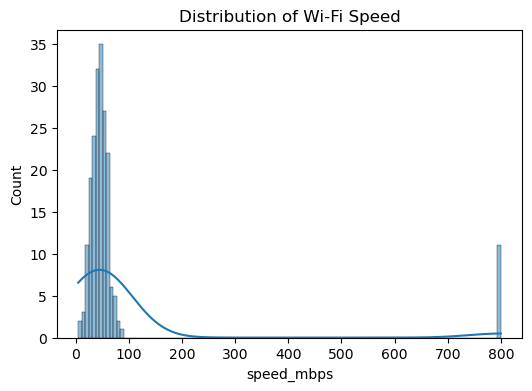

In [10]:
plt.figure(figsize=(6,4))
sns.histplot(df['speed_mbps'], kde=True)
plt.title("Distribution of Wi-Fi Speed")
plt.show()


**Comment:**
The histogram shows that most Wi-Fi speeds are concentrated between 30 and 60 Mbps.
However, there is a long right tail caused by extremely high speed values, which
confirms the presence of outliers in the dataset.


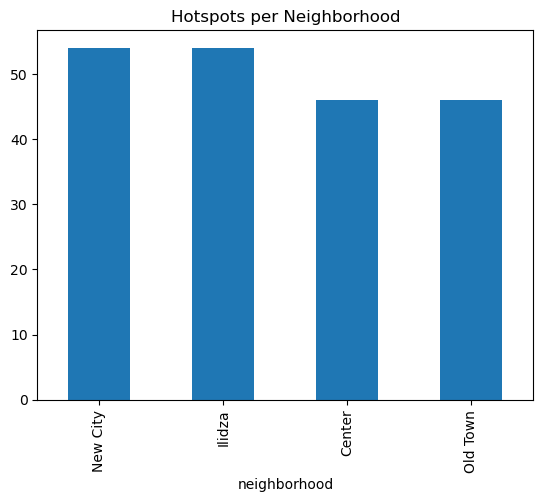

In [11]:
df['neighborhood'].value_counts().plot(kind='bar')
plt.title("Hotspots per Neighborhood")
plt.show()


**Comment:**
This bar chart shows the distribution of Wi-Fi hotspots across neighborhoods.
Some neighborhoods have more hotspots than others, which may affect the average
internet speed and availability of Wi-Fi services in those areas.


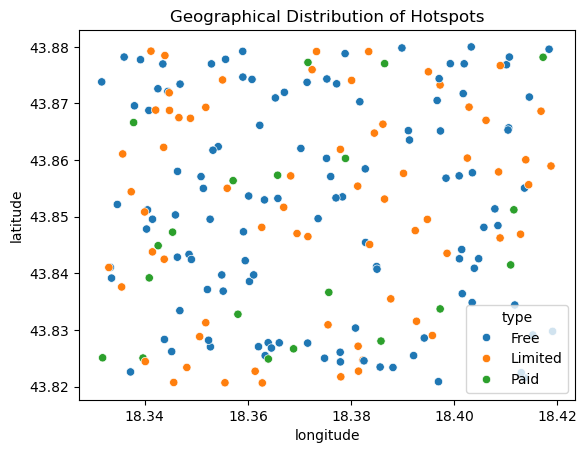

In [37]:
sns.scatterplot(x='longitude', y='latitude', hue='type', data=df)
plt.title("Geographical Distribution of Hotspots")
plt.show()


**Comment:**
The scatter plot illustrates the geographical distribution of Wi-Fi hotspots.
Different Wi-Fi types appear to be spread across the city without a strong
geographical clustering, indicating that hotspot types are relatively evenly
distributed.


## 4. Outlier Detection


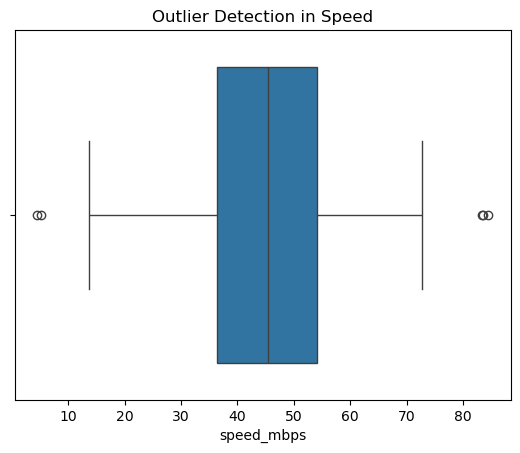

In [39]:
sns.boxplot(x=df['speed_mbps'])
plt.title("Outlier Detection in Speed")
plt.show()

**Comment:**

The boxplot clearly indicates the presence of extreme outliers in the `speed_mbps`
attribute, with several values far above the upper quartile. These unusually high
internet speed values significantly increase the variability of the data and may
negatively affect statistical analysis and machine learning model performance.


**Outlier Handling – Method 1: Replacing with Median**


In [40]:
median_speed = df['speed_mbps'].median()
df_median = df.copy()
df_median.loc[df_median['speed_mbps'] > 150, 'speed_mbps'] = median_speed

**Outlier Handling – Method 2: Removing Outliers**

In [41]:
df_removed = df[df['speed_mbps'] <= 150]

**Comment:**

To handle the detected outliers, two different methods were applied. In the first
approach, extreme values were replaced with the median speed, which is more robust
to outliers than the mean. In the second approach, observations with internet speeds
above a defined threshold were removed from the dataset. These methods help reduce
the influence of extreme values and improve the reliability of further analysis and
classification models.


## 5. Missing Values Handling


In [15]:
df.isnull().sum()


neighborhood     0
type             0
provider        11
latitude         0
longitude        0
speed_mbps       0
dtype: int64

**Comment on Missing Values Handling:**

The missing value analysis shows that only the `provider` column contains null values,
while all other attributes are complete. Since `provider` is a categorical variable,
missing values were replaced with the label "Unknown" instead of using statistical
measures such as mean or median. This approach preserves all observations and avoids
introducing misleading numerical information. Different imputation methods were not
required for other columns because they did not contain missing values.


In [18]:
df['provider'] = df['provider'].fillna('Unknown')


## 6. Missing Values Visualization


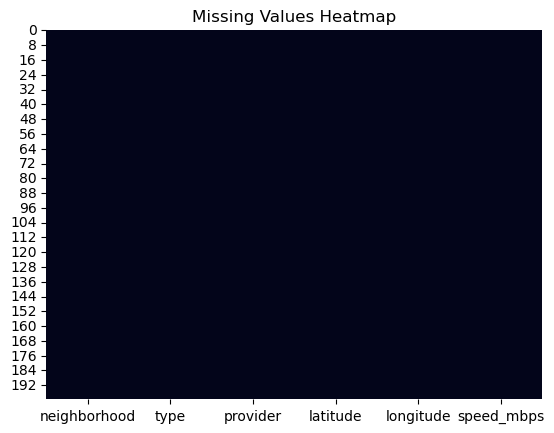

In [19]:
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()


**Comment on Missing Values Visualization:**

The heatmap visualization shows that missing values are present only in the
`provider` column and are randomly distributed across the dataset. There is no
visible correlation between missing values and other features, which suggests that
the missingness is not systematic.


## 7. Classification Using Logistic Regression


In [21]:
le = LabelEncoder()
df_encoded = df.copy()

for col in ['neighborhood', 'type', 'provider']:
    df_encoded[col] = le.fit_transform(df_encoded[col])


In [22]:
df_encoded['is_free'] = (df['type'] == 'Free').astype(int)

X = df_encoded[['neighborhood', 'speed_mbps', 'latitude', 'longitude']]
y = df_encoded['is_free']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LogisticRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy_score(y_test, predictions)


0.575

In [23]:
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.67      0.11      0.19        18
           1       0.57      0.95      0.71        22

    accuracy                           0.57        40
   macro avg       0.62      0.53      0.45        40
weighted avg       0.61      0.57      0.48        40



**Comment on Classification Results:**

Logistic Regression was applied to classify whether a Wi-Fi hotspot is free or not.
The model achieved an accuracy of approximately 57%, which indicates moderate
classification performance. The recall value for the "Free" class is relatively high,
showing that the model is successful at identifying free Wi-Fi hotspots. However,
the performance for the other class is weaker. This result is expected since the
dataset is synthetically generated and does not contain strong real-world patterns.
Overall, the model demonstrates the complete classification workflow.
